# Firefighting Drone with Reinforcement Learning based Control

## Tomasz Lewicki

## Motivation

- Wildfire Problem
- Tangentially Related to my Thesis Project

# Environment

### Environment Model

- cellular simulation of a wildfire
- on $N \times N$ grid lattice
- each cell has:
    + state $ s \in \{0,1\}$ (i.e. `intact` or `burning`)
    + fuel $ f \in [0,255]$
- in each step, every `burning` cell:
    + looses `burn_rate` amount of fuel
    + sets neighboring cells on fire with certain probability $p \in [0,1]$

### Not limited to wildfires!
- imagine cells can be shuffled (travel)
- we have a classic SIR* epidemic model where fire is the virus
    
*_(SIR = Susceptible-Infectious-Removed)_

### More info:

__Julian and Kochenderfer__ *Distributed Wildfire Surveillance with AutonomousAircraft using Deep Reinforcement Learning* https://arxiv.org/abs/1810.04244

__Haksar and Schwager__   *Distributed Deep Reinforcement Learning for Fighting Forest Fires with a Network of Aerial Robots* https://msl.stanford.edu/sites/g/files/sbiybj8446/f/root_0.pdf

# Environment Demo

In [1]:
from environment import Environment

# Initialize environment with 10k cells
env = Environment(shape=(100, 100), tree_density=0.55, random_seed=260)

# Environment API

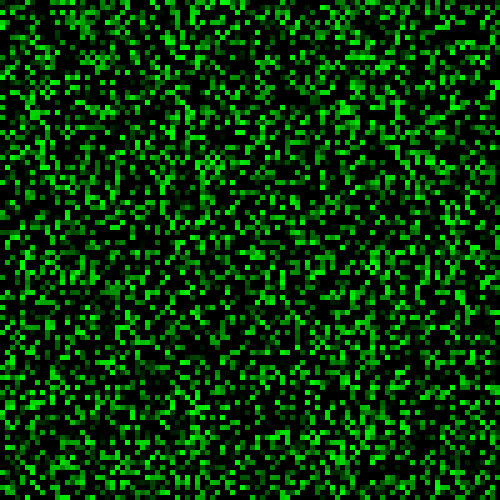

In [2]:
# Image with the map of fuel ("forrest") 45% cells are empty 
# and 55% have amounts of fuel drawn from uniform distribution
env.fuel()

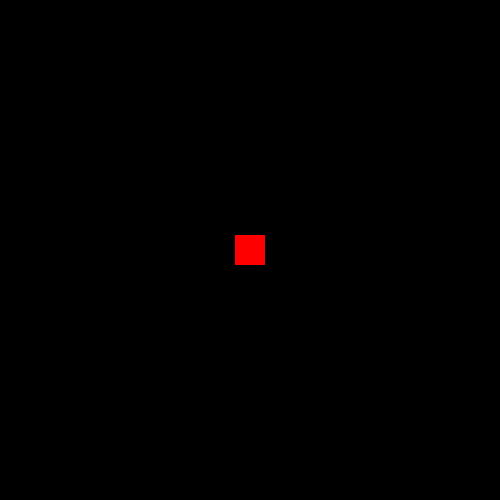

In [3]:
# With .fire() method we can see the rendered map of fire
env.fire()

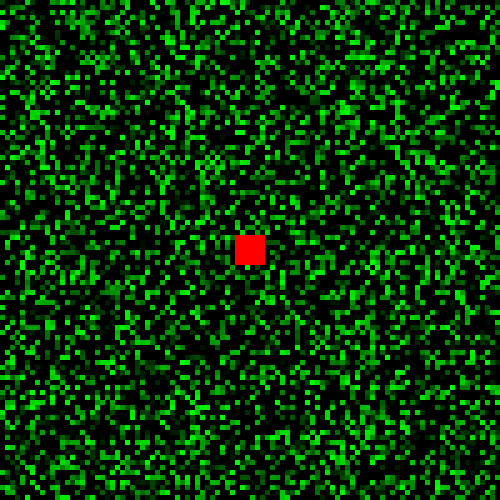

In [4]:
# Finally, .snapshot() method has shows combined view
env.snapshot()

### Let's run a few steps

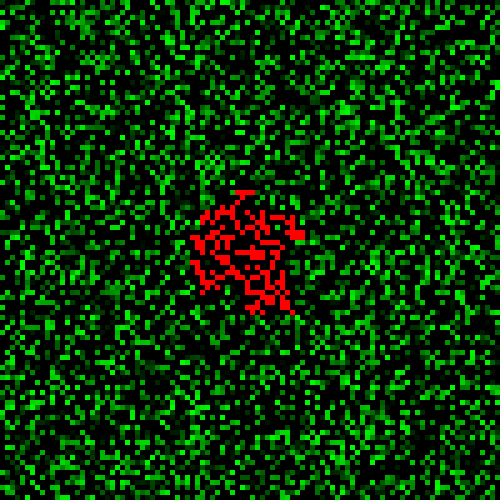

In [5]:
for _ in range(10):
    env.simulation_step()
    
env.snapshot()

### Let's run some more steps

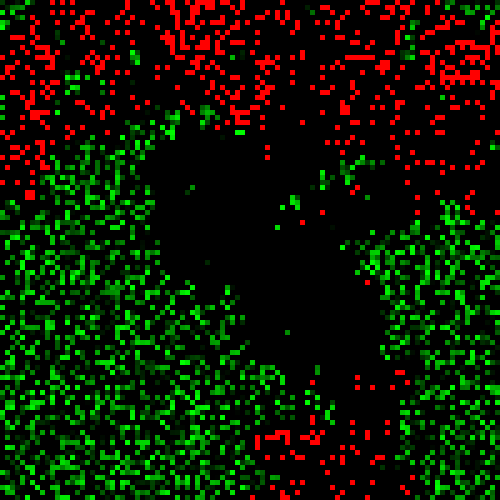

In [6]:
for _ in range(100):
    env.simulation_step()
env.snapshot() # The wildfire simulation is unpredictable & extremely highly sensitive to initial conditions (just like in reality)

# Performance

In [7]:
# 10 000 cells @ ~2000 FPS
%timeit env.simulation_step()

562 µs ± 6.78 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
# 1M cells @ ~20FPS
env = Environment(shape=(1000, 1000), tree_density=0.55, random_seed=260)

%timeit -n 100 env.simulation_step()

52 ms ± 1.84 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


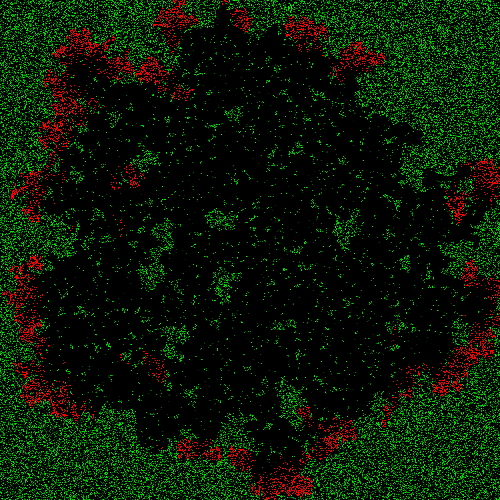

In [9]:
# snapshot with 1M cells
env.snapshot()

In [10]:
# 16M cells ~1FPS
env = Environment(shape=(4000, 4000), tree_density=0.55, random_seed=None)

%time env.simulation_step()

# Beyond that, probably makes sense to move the simulation to GPU

CPU times: user 859 ms, sys: 67.9 ms, total: 927 ms
Wall time: 925 ms


# API for RL training

- Implemented from scratch by me
- sticking to OpenAI `gym` API & conventions

In [11]:
def observe(self, drone_pos, fov=[5, 5]):
    """
    Get observations within fov from drone_pos
    """
    x, y = drone_pos
    fov_x, fov_y = int((fov[0] - 1) / 2), int((fov[1] - 1) / 2)
    view = self._state_map[y - fov_y : y + fov_y + 1, x - fov_x : x + fov_x + 1]

    return view

In [12]:
def extinguish(self, drone_pos, fov=[3, 3]):
    """
    extinguish cells within fov below drone_pos
    """
    x, y = drone_pos
    fov_x, fov_y = int((fov[0] - 1) / 2), int((fov[1] - 1) / 2)

    slice_y = slice(y - fov_y, y + fov_y + 1)
    slice_x = slice(x - fov_x, x + fov_x + 1)
    view = self._state_map[slice_y, slice_x]

    fire_count = self._state_map[slice_y, slice_x].sum()

    # set sate to 0 (extinguish)
    self._state_map[y - fov_y : y + fov_y + 1, x - fov_x : x + fov_x + 1] = 0

    return fire_count

In [13]:
# Standard methods for RL training

def step(self, drone_pos, action, sim_step_every=1):
    """
    environment step
    returns observation and reward
    """
    if self._step_cnt % sim_step_every == 0:
        self.simulation_step(burn_rate=3, ignition_prob=0.2)
    self._step_cnt += 1

    x, y = drone_pos
    observation = self.observe(drone_pos)
    reward = self.extinguish(drone_pos)

    return observation, reward

def reset(self):
    """
    restores the initial state of the environment
    """
    self._state_map = np.zeros(shape, dtype=np.uint8)
    self.ignite_center()
    

@property
def done(self):
    """
    Termminal state of the environment.
    Returns True if the fire
    a) was put out
    b) died out by itself
    """
    return True if self._state_map.sum() == 0 else False

# For more implementation details: 
# https://github.com/tomek-l/rl-firefighting

# Agent